In [3]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Library that we have created
import Utilities as ut

%matplotlib notebook

In [2]:
# Machine Learning Libraries

# Import clustering libraries
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Preparation

In [4]:
# Open the dataset
df = pd.read_csv("dataset/Other/dataset.csv", index_col=[0])

# Drop useless columns
df = df.drop(["MW", "home_team_name", "away_team_name"],1)

In [5]:
X = df.drop("Result",1).astype(float)
y = df.Result

## Prediction

In [6]:
# Split the dataframe in 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 42)

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Train a decision tree classifier
rf = RandomForestClassifier(n_estimators = 21, random_state = 42)
rf.fit(X_train, y_train)

# Predict 
test_pred = rf.predict(X_test)

# Adding the prediction to the dataframe
X_test["Reality"] = y_test
X_test["Prediction"] = test_pred

# Check if the prediction was True
X_test["Check"] = ut.check_the_pred(X_test, "Reality", "Prediction")
X_test.head(5)

,Hteam_G_got_M,Ateam_G_got_M,Hteam_G_opp_M,Ateam_G_opp_M,Hteam_CC_got_M,Ateam_CC_got_M,Hteam_CC_opp_M,Ateam_CC_opp_M,Hteam_F_got_M,Ateam_F_got_M,...,temperatureMax,temperatureMin,uvIndex,visibility,windBearing,windGust,windSpeed,Reality,Prediction,Check
482,0.513514,0.648649,0.945946,0.459459,2.351351,3.189189,4.000000,1.594595,5.567568,6.567568,...,42.48,33.09,0.0,5.690,305.0,10.14,2.92,D,H,False
65,0.351351,0.297297,0.405405,0.594595,1.729730,1.486486,1.405405,1.756757,3.189189,2.594595,...,54.58,44.43,0.0,4.894,165.0,12.47,3.40,H,H,True
926,1.432432,0.864865,0.918919,1.189189,4.351351,3.351351,4.567568,5.837838,9.756757,9.270270,...,52.88,43.97,5.0,6.215,291.0,19.13,11.49,H,H,True
481,0.594595,0.810811,0.918919,0.621622,3.297297,3.108108,2.621622,3.216216,5.081081,5.000000,...,46.62,38.37,1.0,6.215,274.0,20.06,7.76,A,D,False
23,0.351351,0.108108,0.432432,0.243243,0.891892,0.837838,1.000000,1.189189,1.702703,1.675676,...,65.46,59.01,2.0,6.083,180.0,21.14,11.22,H,H,True


# Clustering

## Elbow Method

In [9]:
"""This is a function in order to search for the optimal number of clusters for
k-means clustering"""

def elbowmethod(df, feat1, feat2):
    
    # Create an Empty List
    Sum_of_squared_distances = []
    
    # Keeping only certain columns
    P = df[[feat1, feat2]] 

    for k in range(1,8) :
        
        # Trying kmeans with different numbers of clusters
        kmeans_model = KMeans(n_clusters = k)
        
        # Fit the model
        kmeans_model.fit(P) 
        
        # Obtain the centroids coordinates
        centroids = kmeans_model.cluster_centers_
    
        # Creating a column with the relative cluster number
        P["cluster"] = kmeans_model.labels_
        
        # Append to our list the sum of squared distances
        Sum_of_squared_distances.append(kmeans_model.inertia_)
        
    # Plot the graph
    plt.plot(range(1,8) , Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()  

<IPython.core.display.Javascript object>


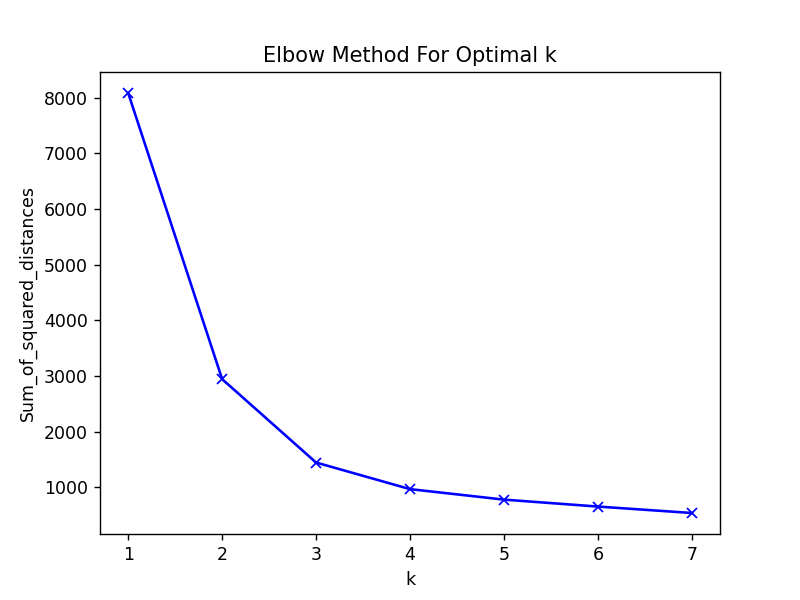

In [10]:
elbowmethod(X_test, "Diff_AT_CC_M","Diff_ov")

From the graph, we can see that the best number of centroids is 3. This is also confirmed by the fact that we have <b>3 possible results</b>: Home win, Draw and Away win.

In [8]:
def kmeansclustering(ncluster, df, feat1, feat2, n1, n2):
    # Create a model with N-cluster
    kmeans_model = KMeans(ncluster) 
    
    # Keep only two features
    P = df[[feat1, feat2]]
    
    # Fit the model
    kmeans_model.fit(P)
    
    # Obtain the centroids coordinates
    centroids = kmeans_model.cluster_centers_
    
    # Creating a column with the relative cluster number
    P["cluster"] = kmeans_model.labels_
    
    # Transforming to a numpy array
    P = P.to_numpy()

    fig, ax = plt.subplots(figsize = (6,5))
    # Plot data colored with labels
    ax.scatter(P[:,0], P[:,1], c= kmeans_model.labels_)
    # Plot centroids
    ax.scatter(centroids[:,0], centroids[:,1], c = 'red', marker = '+', s = 100) 
    plt.xlabel(n1)
    plt.ylabel(n2)

    # Print the error
    # Log the error (named intertial_ by scikit)
    print ("Error =", kmeans_model.inertia_)

<IPython.core.display.Javascript object>


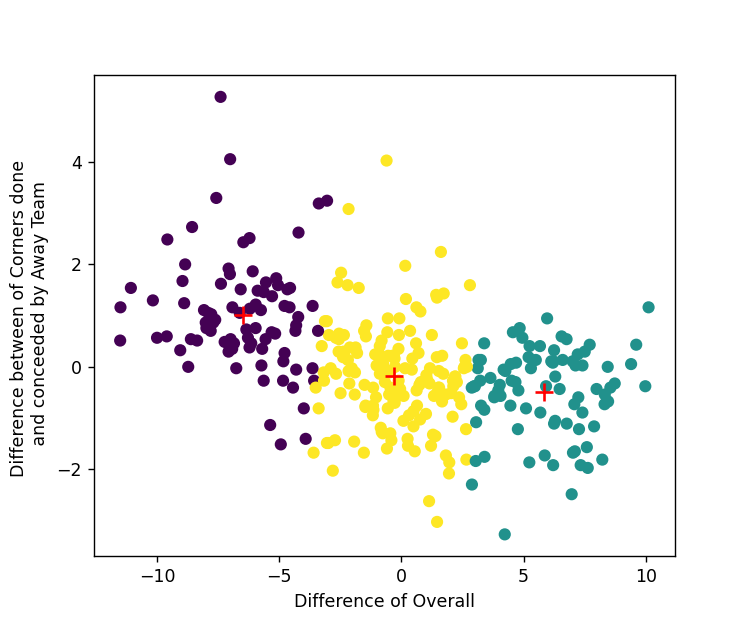

Error = 1407.843480071726


In [10]:
kmeansclustering(3, X_test, "Diff_ov", "Diff_AT_CC_M", "Difference of Overall" , "Difference between of Corners done \n and conceeded by Away Team")

For this plot, we decided to choose the most important features:
<ol>
<li>Difference between  Corners done and conceeded by Away Team</li>
<li>Difference of Overall</li>
</ol>
These clusters reflect the predictions of our models.Given the values of the two axes for a match, we can insert a point in the graph and see to which cluster the match belongs. This way, we can state the outcome of the match, though with a percentage of uncertainty.

In [14]:
'''We make a function that given two variables (feat1 and feat2) makes a scatterplot 
based on if our model predicted the match correctly or not.
If the match was predicted correctly the dot is green, if wrong it is red'''

def clustersearch (df, feat1, feat2, n1, n2): 
    
    # Create a dataframe with only the columns that we want to plot
    P = df[[feat1, feat2, 'Check']]
    # Transform to Numpy array
    P = P.to_numpy()
    
    # Chhosing the colors
    color_map = {False : 'red', True : 'green'}
    
    # Map the label
    label_color = [color_map[l] for l in df['Check']]
    
    fig = plt.figure() 
    fig.suptitle('Cluster', fontsize = 15) 
    plt.xlabel(n1, fontsize = 13) 
    plt.ylabel(n2, fontsize = 13) 
    plt.scatter(P[:,0], P[:,1], c = label_color, alpha = 0.3) 
    plt.show()

<IPython.core.display.Javascript object>


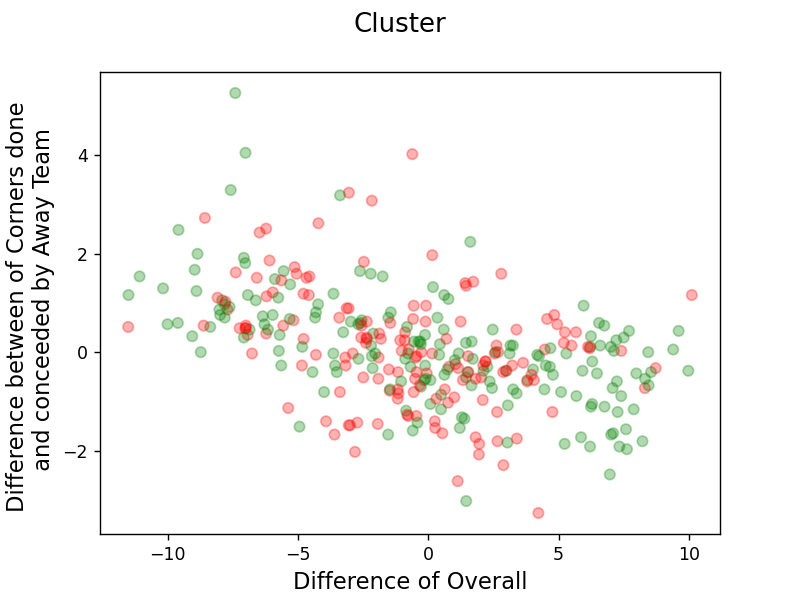

In [15]:
clustersearch(X_test, "Diff_ov", "Diff_AT_CC_M", "Difference of Overall" , "Difference between of Corners done \n and conceeded by Away Team")

In the plot there are 2 kinds of points: <b>red ones for wrong predictions</b>, <b>green ones for right predictions</b>. 
 We can observe that there is a high concentration of red points in the middle part of the graph. This can be attributed to the fact that it is very <b>difficult to predict a Draw.</b> On the other hand, there is less of a prevalence of wrong predictions on the sides of the plot. Therefore, we can conclude that <b>the result is easier to predict if it is a Home win or an Away win.</b>

## From a mathematical point of view

In [15]:
# Selecting only some columns
dataframe = X_test[["Diff_ov","Check"]]
# Making the absolute value of the difference between Overall ratings
dataframe['Diff_ov'] = dataframe['Diff_ov'].abs()
# Sorting Values by highest Diff_ov 
dataframe = dataframe.sort_values(by = 'Diff_ov', ascending = False)
# Counting Right and Wrong predictions
dataframe.head(20)['Check'].value_counts()

True     15
False     5
Name: Check, dtype: int64

In [16]:
# Selecting only some columns
dataframe = X_test[["Diff_ov","Check"]]

# Making the absolute value of the difference between Overall ratings
dataframe['Diff_ov'] = dataframe['Diff_ov'].abs()
# Sorting Values by the lowest Diff_ov 
dataframe = dataframe.sort_values(by = 'Diff_ov', ascending = True)
# Counting Right and Wrong predictions
dataframe.head(20)['Check'].value_counts()

True     10
False    10
Name: Check, dtype: int64

In the first chunk of code we take the 20 matches with highest difference in Overall rating (absolute value), while on the second chunk of code we take the 20 matches with lowest difference in Overall rating (absolute value).

We can observe that the accuracy of the first chunk is higher than the accuracy of the second chunk: this is the confirmation of what shown in the plot.